# **Predicción de Riesgo de derrumbamiento - Terremotos**

**Autor**: Jonatan Santana González  
**Fuente del reto**: [DrivenData - Nepal Earthquake Damage](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/)

## **Introducción**

El objetivo de este ejercicio es desarrollar un modelo predictivo capaz de estimar el nivel de daño estructural en los edificios tras un terremoto, utilizando un conjunto de características geográficas, estructurales y de uso del edificio.

Esta tarea se enmarca en el contexto del terremoto de Nepal de 2015, donde la recopilación de datos estructurales permite abordar el problema de priorización en la respuesta de emergencia. La predicción automatizada del grado de daño puede ayudar a optimizar los recursos en situaciones de desastre, orientando la inspección y reconstrucción de edificios de manera eficiente.

El problema es una clasificación multiclase con tres niveles de daño:  
- **1**: Daño leve  
- **2**: Daño moderado  
- **3**: Daño grave  

El dataset se compone de miles de ejemplos anonimizados y estructurados, que reflejan condiciones reales de los edificios antes del evento sísmico. La métrica oficial para evaluar el rendimiento de los modelos es el **F1 score micro**.

### **Instalación de librerias necesarias**

A continuación, se instalan todas las librerías necesarias para el desarrollo del proyecto. Esto incluye herramientas para manipulación de datos, visualización, modelos de boosting, optimización de hiperparámetros y evaluación automática de varios modelos base.

Se instala lo siguiente:

- `numpy`, `pandas`: manipulación y análisis de datos.
- `scikit-learn`: algoritmos clásicos de machine learning y utilidades.
- `xgboost`, `lightgbm`, `catboost`: algoritmos de boosting.
- `optuna`: optimización de hiperparámetros.
- `matplotlib`, `seaborn`: visualización de datos y resultados.
- `lazypredict`: evaluación rápida de múltiples modelos base.
- `imbalanced-learn`: tratamiento de datasets desbalanceados.

In [13]:
!pip install numpy pandas scikit-learn xgboost lightgbm catboost optuna matplotlib seaborn lazypredict imbalanced-learn --quiet

You should consider upgrading via the 'C:\Users\isard\Documents\Terremotos\terremoto310_env\Scripts\python.exe -m pip install --upgrade pip' command.


### **Importación de librerías**

A continuación se importan todas las librerías necesarias para el análisis, preprocesamiento, modelado, validación y visualización de resultados del proyecto:

- **Manipulación de datos**:
  - `pandas`, `numpy`: manejo y análisis de estructuras de datos.

- **Visualización**:
  - `matplotlib.pyplot`, `seaborn`: representación gráfica de datos, correlaciones, métricas, etc.

- **Preprocesamiento y transformación**:
  - `StandardScaler`, `LabelEncoder`, `label_binarize`, `OneHotEncoder`, `RobustScaler`: transformación y codificación de variables.
  - `ColumnTransformer`: permite aplicar diferentes transformaciones a diferentes columnas.
  - `Pipeline` (de sklearn e imblearn): para encadenar pasos de preprocesamiento y modelado.
  - `SMOTE`: técnica de sobremuestreo para abordar el desbalanceo de clases.

- **Reducción de dimensionalidad**:
  - `PCA`: análisis de componentes principales para reducción de dimensiones.

- **Análisis de correlación y clustering**:
  - `linkage`, `dendrogram` (de scipy): construcción de dendogramas para agrupación jerárquica.

- **División de datos y validación cruzada**:
  - `train_test_split`, `cross_val_score`, `cross_val_predict`: división y validación del rendimiento del modelo.
  - `GridSearchCV`, `RandomizedSearchCV`: búsqueda de hiperparámetros.
  - `StratifiedKFold`: validación cruzada estratificada.

- **Modelos de clasificación**:
  - `DecisionTreeClassifier`, `RandomForestClassifier`, `GradientBoostingClassifier`: modelos clásicos basados en árboles.
  - `SVC`: soporte vectorial (SVM).
  - `XGBClassifier`, `LGBMClassifier`, `CatBoostClassifier`: algoritmos de boosting optimizados.
  - `LazyClassifier`: comparación rápida de múltiples modelos base.

- **Evaluación del modelo**:
  - `f1_score`, `make_scorer`, `classification_report`, `confusion_matrix`, `ConfusionMatrixDisplay`: métricas de rendimiento.
  - `roc_curve`, `auc`, `roc_auc_score`, `RocCurveDisplay`: evaluación mediante curvas ROC y AUC.

- **Optimización**:
  - `optuna`: optimización de hiperparámetros mediante búsqueda inteligente.

- **Utilidades**:
  - `time`: medición de tiempos de ejecución.

In [ ]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y transformación
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Análisis de correlación y clustering
from scipy.cluster.hierarchy import linkage, dendrogram

# División y validación de datos
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    GridSearchCV, RandomizedSearchCV, StratifiedKFold
)

# Modelos de clasificación
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from lazypredict.Supervised import LazyClassifier

# Métricas y visualización de resultados
from sklearn.metrics import (
    f1_score, make_scorer, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay
)

# Optimización de hiperparámetros
import optuna

# Otros
import time

### **Carga de los datos**

Se procede a la lectura de los archivos proporcionados para la competición, utilizando enlaces directos desde GitHub. Los datasets disponibles son:

- `train_values.csv`: contiene las características estructurales de los edificios utilizados para el entrenamiento.
- `train_labels.csv`: contiene la variable objetivo `damage_grade`, que representa el nivel de daño sufrido por cada edificio.
- `test_values.csv`: contiene los datos de los edificios sin etiqueta, sobre los cuales se realizará la predicción final.

Los archivos son cargados utilizando `pandas.read_csv()` y se imprime su dimensión para verificar la correcta carga de los datos.

In [5]:
url_train_values = "https://raw.githubusercontent.com/jonatansg/CEIABD/refs/heads/main/Earthquake/train_values.csv"
url_train_labels = "https://raw.githubusercontent.com/jonatansg/CEIABD/refs/heads/main/Earthquake/train_labels.csv"
url_test_values  = "https://raw.githubusercontent.com/jonatansg/CEIABD/refs/heads/main/Earthquake/test_values.csv"

train_values = pd.read_csv(url_train_values)
train_labels = pd.read_csv(url_train_labels)
test_values = pd.read_csv(url_test_values)

print(train_values.shape, train_labels.shape, test_values.shape)

(260601, 39) (260601, 2) (86868, 39)


### **Análisis exploratorio inicial y normalización**

En este paso se realiza un análisis básico del conjunto de datos de entrenamiento:

1. **Detección de valores nulos:** Se comprueba si existen valores faltantes en el dataset.
2. **Detección de duplicados:** Se verifica si hay edificios repetidos utilizando el identificador `building_id`.
3. **Tipos de datos:** Se identifican los tipos de columnas presentes (numéricas, categóricas, etc.).
4. **Estadísticas descriptivas:** Se presentan métricas como media, desviación estándar, valores mínimos y máximos de las columnas numéricas.
5. **Distribución de la variable objetivo:** Se analiza la proporción de cada clase en `damage_grade`, para identificar posibles desequilibrios.
6. **Valores únicos por columna:** Se observan columnas con baja cardinalidad, lo cual puede ser útil para la selección de características.
7. **Normalización:** Se normalizan las variables numéricas (excluyendo `building_id`) mediante `StandardScaler` de `scikit-learn`, lo cual es fundamental para algunos algoritmos de aprendizaje automático.

In [6]:
# 1. Valores nulos
print("Valores nulos totales:", train_values.isnull().sum().sum())

# 2. Duplicados por 'building_id'
print("Duplicados por 'building_id':", train_values.duplicated(subset='building_id').sum())

# 3. Tipos de datos
print("\nTipos de datos:")
print(train_values.dtypes.value_counts())

# 4. Estadísticas descriptivas
print("\nEstadísticas básicas:")
display(train_values.describe())

# 5. Distribución de la variable objetivo
print("\nDistribución de 'damage_grade':")
display(train_labels["damage_grade"].value_counts(normalize=True))

# 6. Columnas con pocos valores únicos (posibles candidatas a eliminación)
print("\nValores únicos por columna (menor a mayor):")
display(train_values.nunique().sort_values().head(10))

# 7. Normalización de variables numéricas (sin building_id)
numeric_cols = train_values.select_dtypes(include='number').drop(columns=['building_id']).columns

scaler = StandardScaler()
scaled_values = scaler.fit_transform(train_values[numeric_cols])
train_scaled = pd.DataFrame(scaled_values, columns=numeric_cols)

print("Forma de los datos normalizados:", train_scaled.shape)

Valores nulos totales: 0
Duplicados por 'building_id': 0

Tipos de datos:
int64     31
object     8
Name: count, dtype: int64

Estadísticas básicas:


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,...,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,525675.48,13.90,701.07,6257.88,2.13,26.54,8.02,5.43,0.09,0.76,...,0.06,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01
std,304545.00,8.03,412.71,3646.37,0.73,73.57,4.39,1.92,0.28,0.43,...,0.25,0.18,0.09,0.03,0.02,0.03,0.01,0.01,0.01,0.07
min,4.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,261190.00,7.00,350.00,3073.00,2.00,10.00,5.00,4.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,525757.00,12.00,702.00,6270.00,2.00,15.00,7.00,5.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,789762.00,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1052934.00,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00



Distribución de 'damage_grade':


damage_grade
2   0.57
3   0.33
1   0.10
Name: proportion, dtype: float64


Valores únicos por columna (menor a mayor):


has_superstructure_adobe_mud              2
has_superstructure_bamboo                 2
has_secondary_use_rental                  2
has_secondary_use_hotel                   2
has_secondary_use                         2
has_secondary_use_agriculture             2
has_superstructure_other                  2
has_superstructure_rc_engineered          2
has_superstructure_rc_non_engineered      2
has_superstructure_cement_mortar_stone    2
dtype: int64

Forma de los datos normalizados: (260601, 30)


El conjunto de datos no contiene valores nulos ni duplicados en la columna `building_id`, lo que indica una buena calidad inicial de los datos. Hay 31 columnas de tipo numérico (`int64`) y 8 de tipo categórico (`object`), por lo que será necesario codificar estas últimas antes de entrenar modelos de aprendizaje automático.

A partir del análisis estadístico, se observa que algunas variables como `age` tienen valores extremos (por ejemplo, un máximo de 995 años), lo cual podría influir negativamente en el entrenamiento si no se normaliza o trata adecuadamente. Variables como `count_floors_pre_eq`, `area_percentage` y `height_percentage` tienen distribuciones más acotadas, con medias razonables y varianzas moderadas.

La variable objetivo `damage_grade` está desbalanceada, siendo la clase 2 (daño medio) la más representada con aproximadamente el 57% de los casos, seguida de la clase 3 (daño severo) con el 33% y finalmente la clase 1 (daño leve) con apenas el 10%. Esta desproporción sugiere que el uso de métricas como `f1_score` con `average='micro'` será más adecuado que la simple exactitud.

Además, se identificaron múltiples variables binarias con solo dos valores únicos (0 o 1), lo cual facilita su uso directo en modelos sin necesidad de codificación adicional. Finalmente, la forma del conjunto de datos es de 260.601 filas por 30 columnas tras la limpieza, lo que confirma un tamaño considerable y adecuado para entrenar modelos complejos.

### **Análisis de correlación entre variables**

En esta fase se estudia la relación entre las variables del conjunto de datos y la variable objetivo `damage_grade`.

- Se realiza una **codificación temporal** de las variables categóricas para poder calcular la correlación de Pearson entre todas las variables numéricas.
- Se crea una tabla que muestra las **variables con mayor y menor correlación** respecto a `damage_grade`, lo cual permite identificar posibles variables predictivas relevantes o redundantes.
- Finalmente, se genera un **mapa de calor** con `seaborn` que visualiza gráficamente el grado de correlación entre todas las variables numéricas, lo cual ayuda a detectar relaciones lineales fuertes o multicolinealidad.

Correlaciones más altas con 'damage_grade':
damage_grade                           1.000000
has_superstructure_mud_mortar_stone    0.291325
count_floors_pre_eq                    0.122308
legal_ownership_status                 0.085684
has_superstructure_stone_flag          0.066039
count_families                         0.056151
has_superstructure_adobe_mud           0.055314
position                               0.055202
height_percentage                      0.048130
geo_level_2_id                         0.043161
Name: damage_grade, dtype: float64

Correlaciones más bajas con 'damage_grade':
has_secondary_use                        -0.079630
has_secondary_use_rental                 -0.083754
has_secondary_use_hotel                  -0.097942
foundation_type                          -0.100601
area_percentage                          -0.125221
has_superstructure_rc_non_engineered     -0.158145
roof_type                                -0.173890
has_superstructure_rc_engineered       

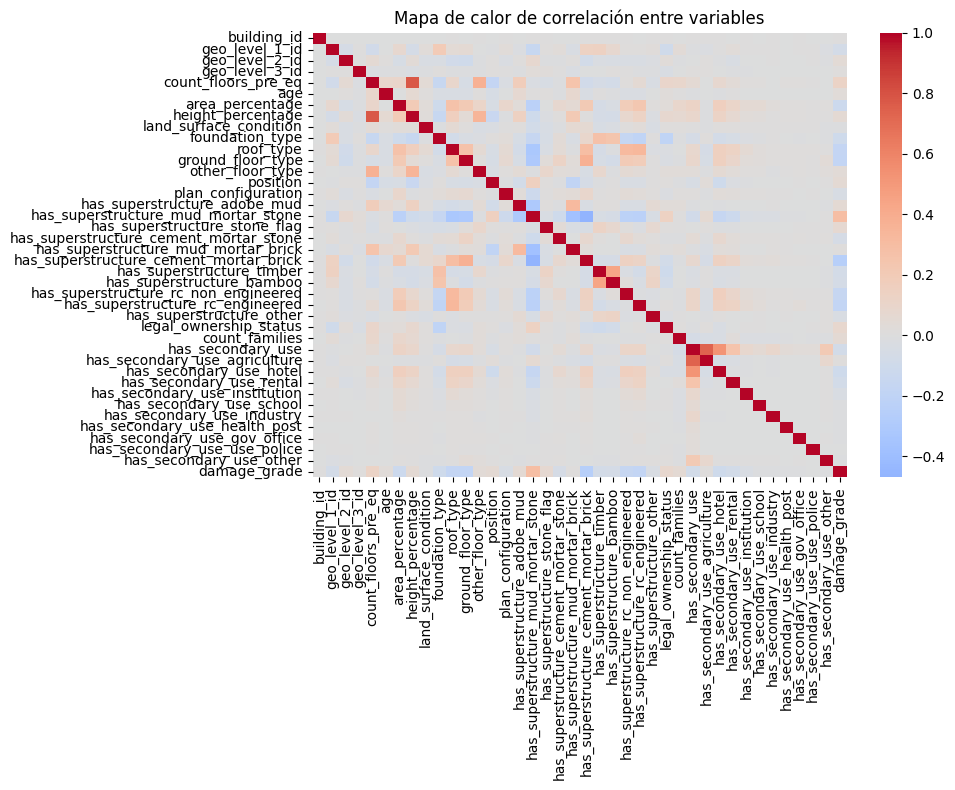

In [ ]:
# Combinar los datos con la variable objetivo
df_corr = train_values.copy()
df_corr = df_corr.merge(train_labels, on="building_id")

# Codificar variables categóricas para el análisis (temporalmente)
df_corr_encoded = df_corr.copy()
for col in df_corr_encoded.select_dtypes(include='object').columns:
    df_corr_encoded[col] = df_corr_encoded[col].astype("category").cat.codes

# Calcular la correlación
correlation = df_corr_encoded.corr(numeric_only=True)

# Extraer correlación con la clase objetivo
target_corr = correlation["damage_grade"].sort_values(ascending=False)

# Mostrar correlaciones más altas y más bajas
print("Correlaciones más altas con 'damage_grade':")
print(target_corr.head(10))

print("\nCorrelaciones más bajas con 'damage_grade':")
print(target_corr.tail(10))

# (opcional) Mapa de calor de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlación entre variables")
plt.tight_layout()
plt.show()

Se ha generado un mapa de calor para visualizar la correlación entre las variables del conjunto de datos. La variable objetivo `damage_grade` presenta correlaciones bajas o moderadas con el resto de variables, lo cual es esperable en un problema complejo como este.

Las variables con **mayor correlación positiva** con `damage_grade` (es decir, aquellas que podrían estar asociadas a un mayor daño) son:

- `has_superstructure_mud_mortar_stone`: 0.29
- `count_floors_pre_eq`: 0.12
- `legal_ownership_status`: 0.08
- `has_superstructure_stone_flag`: 0.07
- `count_families`: 0.06
- `has_superstructure_adobe_mud`: 0.06
- `position`: 0.06
- `height_percentage`: 0.05
- `geo_level_2_id`: 0.04

Estas variables podrían tener un mayor peso en la predicción del daño estructural, especialmente las relacionadas con materiales de construcción.

Por otro lado, las variables con **mayor correlación negativa** con `damage_grade` (es decir, asociadas a menor daño) son:

- `has_superstructure_cement_mortar_brick`: -0.25
- `ground_floor_type`: -0.18
- `has_superstructure_rc_engineered`: -0.18
- `roof_type`: -0.17
- `has_superstructure_rc_non_engineered`: -0.16
- `area_percentage`: -0.13
- `foundation_type`: -0.10
- `has_secondary_use_hotel`: -0.10
- `has_secondary_use_rental`: -0.08
- `has_secondary_use`: -0.08

Estas características podrían estar relacionadas con una mayor resistencia estructural o edificios menos propensos a daños severos.

Aunque los coeficientes no son muy elevados, pueden ser útiles en la selección de características para el entrenamiento de los modelos. Se tendrá en cuenta esta información, junto con técnicas como árboles de decisión o análisis de importancia de variables, para seleccionar las variables más relevantes.

### **Análisis de agrupación de variables y reducción de dimensionalidad**

Para comprender mejor la estructura interna del conjunto de datos y posibles agrupaciones entre variables, se aplicaran tres técnicas complementarias:

1. **Dendograma jerárquico**:
   - Utiliza la matriz de correlación entre variables numéricas para construir un árbol jerárquico que representa similitudes entre variables.
   - Permite identificar grupos de variables que tienden a comportarse de forma similar.

2. **Clustermap de correlaciones**:
   - Es una representación gráfica que reorganiza las variables en función de sus correlaciones, utilizando un mapa de calor y técnicas de clustering.
   - Facilita la detección de agrupaciones fuertes y relaciones redundantes.

3. **Análisis de Componentes Principales (PCA)**:
   - Reduce la dimensionalidad del dataset a dos componentes principales que retienen la máxima varianza posible.
   - Se visualizan las observaciones proyectadas en el plano PC1 vs PC2, permitiendo observar patrones o separaciones naturales entre grupos.

Estas herramientas son útiles para realizar una **selección de características** más informada y para tener una idea inicial de la estructura de los datos.

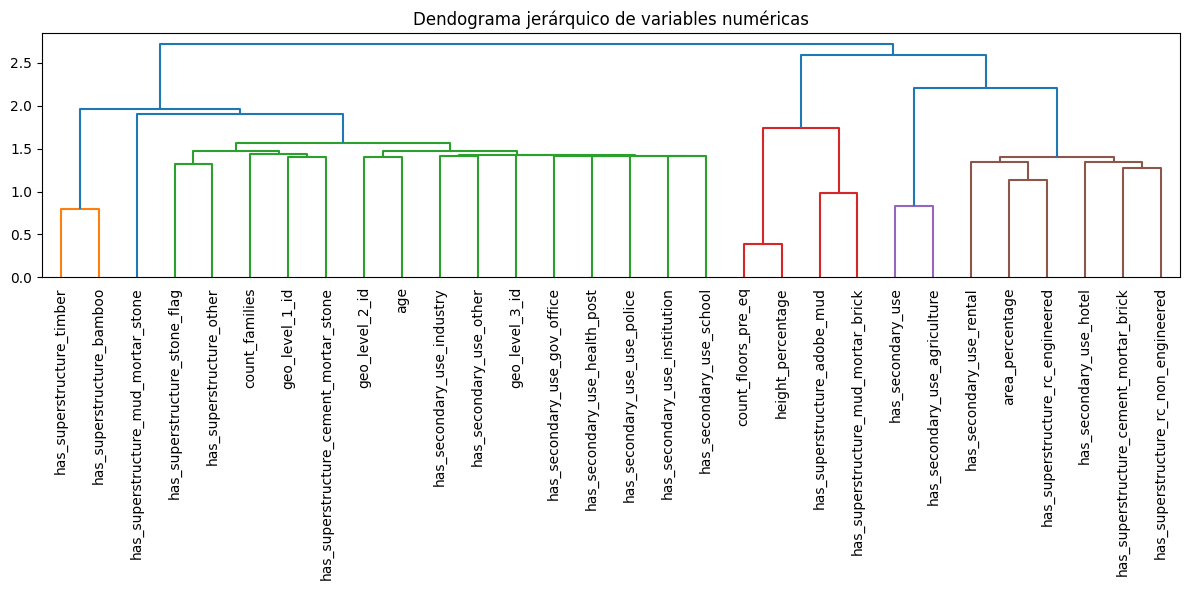

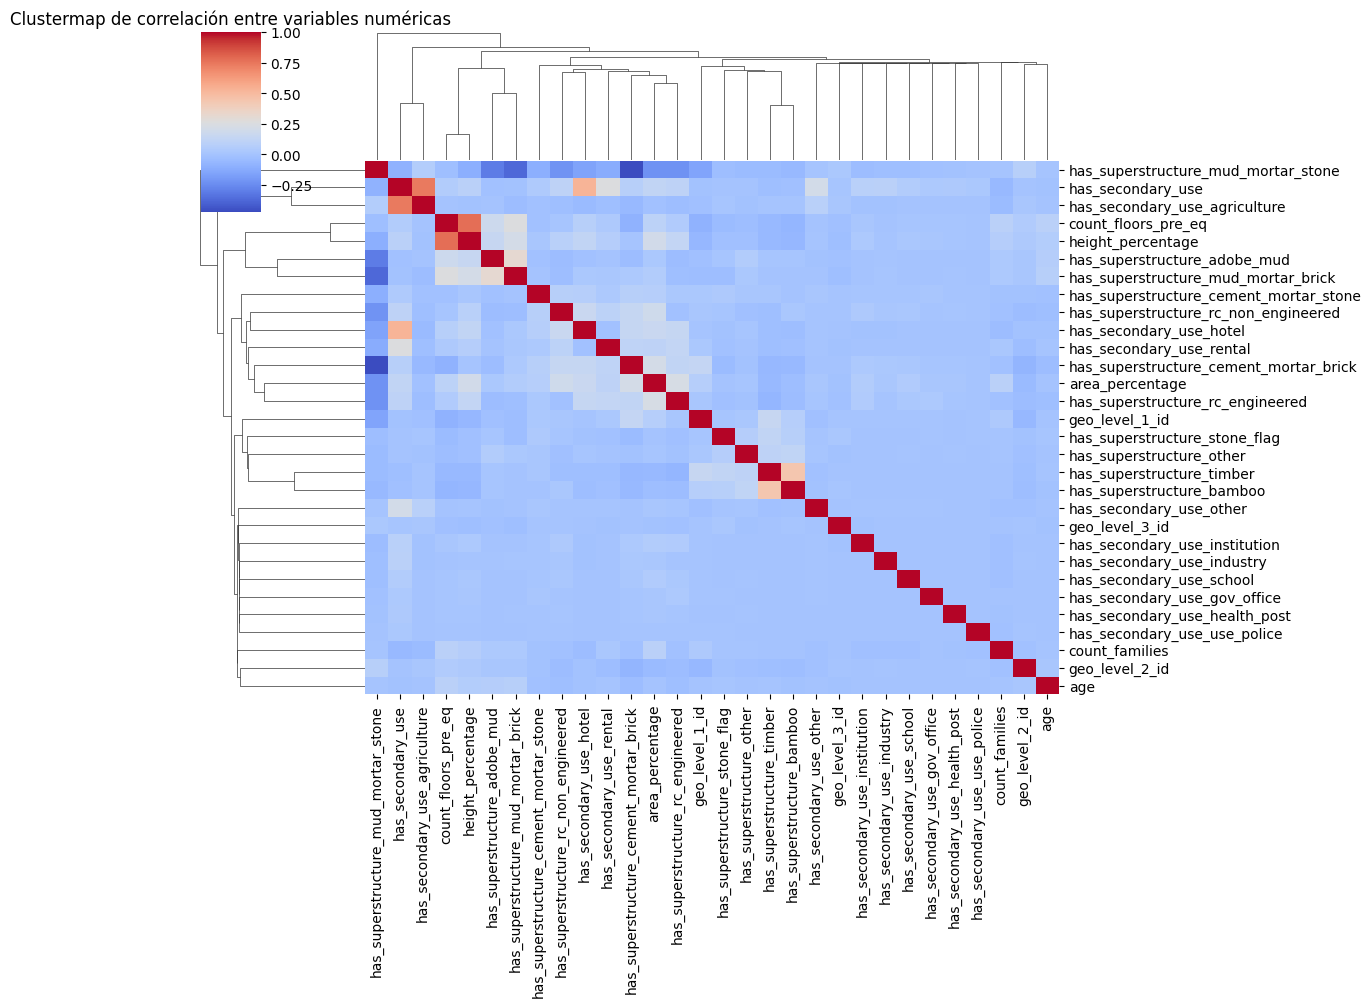

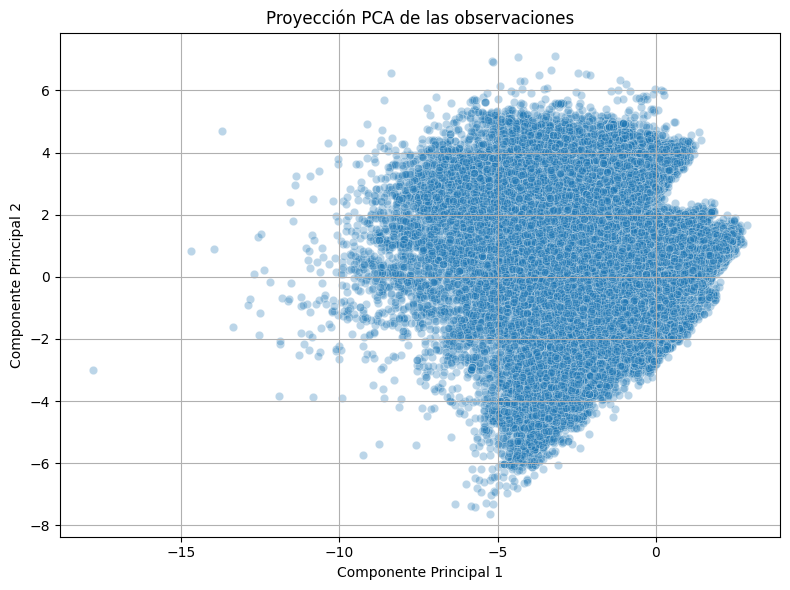

In [ ]:
# Seleccionar solo variables numéricas y eliminar 'building_id'
df_num = train_values.select_dtypes(include='number').drop(columns=['building_id'])

# --------------------------------------
# 1. Dendograma jerárquico tradicional
# --------------------------------------
corr = df_num.corr()
linked = linkage(corr, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=corr.columns, leaf_rotation=90)
plt.title("Dendograma jerárquico de variables numéricas")
plt.tight_layout()
plt.show()

# --------------------------------------
# 2. Clustermap de correlación reordenada
# --------------------------------------
sns.clustermap(corr, cmap='coolwarm', figsize=(12, 10), annot=False)
plt.title("Clustermap de correlación entre variables numéricas")
plt.show()

# --------------------------------------
# 3. PCA: visualización de agrupación de variables
# --------------------------------------

# Normalizar datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# Aplicar PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Crear dataframe PCA
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Graficar PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.3)
plt.title("Proyección PCA de las observaciones")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

Se han aplicado diferentes técnicas visuales para apoyar la selección de características relevantes:

1. **Dendrograma jerárquico de variables numéricas**  
   Esta visualización agrupa las variables que presentan comportamientos similares, permitiendo identificar redundancias o relaciones estructurales. Por ejemplo, se observa que variables como `has_superstructure_timber` y `has_superstructure_bamboo` están estrechamente relacionadas, al igual que `count_floors_pre_eq`, `height_percentage` y `has_superstructure_adobe_mud`. Esta agrupación puede ser útil para reducir la dimensionalidad manteniendo representatividad.

2. **Clustermap de correlación**  
   La matriz de correlación jerarquizada confirma que muchas variables tienen baja o moderada relación entre sí, lo que sugiere que pueden aportar información complementaria. Algunos clústeres de alta correlación, como los formados por las variables relacionadas con estructuras de cemento y ladrillo, podrían permitir seleccionar solo una de ellas para evitar multicolinealidad.

3. **PCA (Análisis de Componentes Principales)**  
   La proyección bidimensional de los datos usando las dos primeras componentes principales muestra una dispersión amplia, lo cual indica que el dataset tiene una varianza significativa distribuida entre varias dimensiones. Esto sugiere que es necesario mantener un número considerable de características para no perder capacidad predictiva.

Estas visualizaciones respaldan la decisión de usar un subconjunto bien elegido de características representativas, y no únicamente aquellas con mayor correlación con la variable objetivo. Se considerarán tanto criterios de importancia estadística como de diversidad informativa en la siguiente fase de selección de variables.

### **Muestreo Estratificado y División de Datos**

Para reducir el volumen de datos en etapas preliminares del modelado, se realiza un **muestreo estratificado del 15%** del dataset original, manteniendo la proporción de clases de la variable `damage_grade`. Este muestreo se hace sin usar `groupby.apply` para evitar advertencias de deprecación de `pandas`.

A continuación, los datos muestreados se procesan de la siguiente forma:
- Se codifican las variables categóricas utilizando codificación ordinal.
- Se elimina la columna `building_id`, que no aporta información predictiva.
- Se realiza una división estratificada del 80% para entrenamiento y 20% para validación, asegurando que las proporciones de clases se mantengan.

Este subconjunto reducido se utilizará para entrenar modelos de forma eficiente, especialmente durante pruebas y ajuste de hiperparámetros.

In [8]:
# Unir valores y etiquetas
data = train_values.merge(train_labels, on="building_id")

# Muestreo estratificado del 15% sin apply
frac = 0.15
sampled_parts = []
for label in data["damage_grade"].unique():
    subset = data[data["damage_grade"] == label]
    sampled = subset.sample(frac=frac, random_state=42)
    sampled_parts.append(sampled)

sampled_data = pd.concat(sampled_parts).reset_index(drop=True)

# Separar variables y etiquetas
X_sampled = sampled_data.drop(columns=["damage_grade"])
y_sampled = sampled_data["damage_grade"]

# Codificación de categóricas
X_sampled_encoded = X_sampled.copy()
for col in X_sampled_encoded.select_dtypes(include='object').columns:
    X_sampled_encoded[col] = X_sampled_encoded[col].astype("category").cat.codes

# Eliminar 'building_id'
X_sampled_encoded = X_sampled_encoded.drop(columns=["building_id"])

# División train/valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_sampled_encoded,
    y_sampled,
    test_size=0.2,
    stratify=y_sampled,
    random_state=42
)

# Resultados
print("Tamaño total del subconjunto reducido:", X_sampled.shape)
print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño validación:", X_valid.shape)
print("\nDistribución de clases en y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en y_valid:")
print(y_valid.value_counts(normalize=True))


Tamaño total del subconjunto reducido: (39091, 39)
Tamaño entrenamiento: (31272, 38)
Tamaño validación: (7819, 38)

Distribución de clases en y_train:
damage_grade
2   0.57
3   0.33
1   0.10
Name: proportion, dtype: float64

Distribución de clases en y_valid:
damage_grade
2   0.57
3   0.33
1   0.10
Name: proportion, dtype: float64


Estos resultados indican que se ha creado un subconjunto de datos más manejable con 39.091 registros y 39 variables (incluyendo la variable objetivo). El conjunto ha sido dividido en entrenamiento y validación con un 80%-20% respectivamente, manteniendo 38 variables predictoras tras separar `damage_grade`.

La variable objetivo ha sido estratificada correctamente, ya que tanto en `y_train` como en `y_valid` se mantiene la misma distribución de clases: aproximadamente un 57% de edificios con daño medio (clase 2), un 33% con daño severo (clase 3), y un 10% con daño leve (clase 1). Esta distribución es clave para asegurar que los modelos entrenados no estén sesgados y que la evaluación durante la validación sea realista y representativa del comportamiento esperado en producción.

### **Modelo 1: Árbol de Decisión (Decision Tree)**

Como primer modelo base, se entrena un clasificador de árbol de decisión (`DecisionTreeClassifier`) utilizando los datos de entrenamiento muestreados.

Para evaluar su desempeño, se emplea la técnica de **validación cruzada con 5 particiones (5-fold cross-validation)**, usando como métrica el **F1-score micro**, que es adecuada en escenarios con clases desbalanceadas como el presente, ya que tiene en cuenta el número total de verdaderos positivos sobre todas las clases.

Esta métrica promedia el desempeño considerando todas las instancias de clasificación de forma global. Se reportan los valores obtenidos por cada fold, así como la media y la desviación estándar.

In [ ]:
# Crear el clasificador
dt_model = DecisionTreeClassifier(random_state=42)

# Definir la métrica de evaluación (f1 micro)
f1_micro = make_scorer(f1_score, average='micro')

# Validación cruzada con 5 folds
scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring=f1_micro)

# Resultados
print("Decision Tree Classifier - F1 micro (validación cruzada):")
print("Resultados por fold:", scores)
print("Media:", scores.mean())
print("Desviación estándar:", scores.std())

Decision Tree Classifier - F1 micro (validación cruzada):
Resultados por fold: [0.60767386 0.61103118 0.60313399 0.61448673 0.60825072]
Media: 0.6089152956496331
Desviación estándar: 0.0037662734148725553


Los resultados muestran un rendimiento estable, con una media de F1-score de aproximadamente **0.609**, y una variabilidad muy baja entre los folds (±0.0038). Esto indica que el modelo es consistente entre diferentes particiones del conjunto de entrenamiento, aunque su capacidad predictiva es moderada y podría mejorarse aplicando técnicas más complejas o modelos más robustos.

### **Modelo 2: Random Forest**

Como segundo modelo se utiliza **Random Forest**, una técnica de ensamblado que construye múltiples árboles de decisión y combina sus resultados para mejorar la precisión y reducir el sobreajuste.

Se realiza una **validación cruzada con 5 folds** utilizando la métrica **F1-score micro**, al igual que en el modelo anterior. Esta métrica proporciona una visión global del rendimiento considerando todas las clases.

Se muestran los resultados de cada partición, así como la media y la desviación estándar del rendimiento.

In [ ]:
# Crear el clasificador
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Validación cruzada con 5 folds
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=f1_micro)

# Resultados
print("Random Forest Classifier - F1 micro (validación cruzada):")
print("Resultados por fold:", rf_scores)
print("Media:", rf_scores.mean())
print("Desviación estándar:", rf_scores.std())

Random Forest Classifier - F1 micro (validación cruzada):
Resultados por fold: [0.68904876 0.68585132 0.67556764 0.68724017 0.68244324]
Media: 0.6840302238541753
Desviación estándar: 0.004752678051909325


El modelo `RandomForestClassifier` mejora significativamente el rendimiento respecto al árbol de decisión simple. Con una media de F1-score de **0.684**, se observa una mejora clara en la capacidad predictiva. Además, la desviación estándar entre folds es baja, lo que indica que el modelo es estable y generaliza bien en distintas particiones del conjunto de entrenamiento.

Este resultado sugiere que Random Forest, al ser un modelo de ensamble, logra capturar relaciones más complejas en los datos y reduce el sobreajuste característico de los árboles individuales. Puede considerarse una opción sólida para incluir en la comparación final de modelos.

### **Modelo 3: Gradient Boosting**

El tercer modelo implementado es **Gradient Boosting Classifier**, una técnica de ensamblado que construye árboles de manera secuencial, donde cada nuevo árbol intenta corregir los errores cometidos por los anteriores. Es especialmente eficaz para mejorar la precisión en conjuntos de datos complejos.

Se aplica **validación cruzada con 5 folds** utilizando la métrica **F1-score micro**, consistente con los modelos anteriores. Se reportan los valores obtenidos en cada fold, así como la media y la desviación estándar para evaluar la estabilidad del modelo.

In [ ]:
# Crear el clasificador
gb_model = GradientBoostingClassifier(random_state=42)

# Validación cruzada con 5 folds
gb_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring=f1_micro)

# Resultados
print("Gradient Boosting Classifier - F1 micro (validación cruzada):")
print("Resultados por fold:", gb_scores)
print("Media:", gb_scores.mean())
print("Desviación estándar:", gb_scores.std())

Gradient Boosting Classifier - F1 micro (validación cruzada):
Resultados por fold: [0.68265388 0.67402078 0.66869204 0.67732651 0.6709306 ]
Media: 0.674724762562831
Desviación estándar: 0.004917823676555411


El modelo `GradientBoostingClassifier` alcanza una media de F1 micro de **0.6747**, ligeramente inferior al rendimiento observado con `RandomForestClassifier`, aunque superior al `DecisionTreeClassifier`. La desviación estándar entre folds es baja, lo que indica buena estabilidad del modelo durante la validación cruzada.

Aunque este modelo puede ofrecer buenas capacidades de generalización y es menos propenso al sobreajuste que los árboles individuales, su rendimiento en este caso concreto no supera al de Random Forest. No obstante, sigue siendo una opción competitiva dentro de los modelos basados en árboles y podría beneficiarse de una mejor optimización de hiperparámetros.

### **Modelo 4: Support Vector Machine (SVM) con ajuste de hiperparámetros**

Para este paso se ha seleccionado un modelo de clasificación basado en máquinas de vectores soporte (`SVC`) como alternativa a los modelos de árbol anteriores. 

Dado que los modelos SVM no escalan bien con conjuntos de datos grandes y presentan una elevada complejidad computacional, se ha optado por trabajar con un subconjunto estratificado de **3.000 muestras**, extraído del conjunto de entrenamiento. Esta decisión se justifica tanto por motivos de eficiencia como por el hecho de que, en este tipo de modelos, **no es necesario entrenar con la totalidad de los datos** para obtener resultados representativos en validación cruzada. De hecho, aplicar `SVC` con kernels no lineales sobre más de 30.000 ejemplos puede generar bloqueos o tiempos de ejecución excesivos.

Con este conjunto reducido se aplican dos técnicas de optimización de hiperparámetros:

- **GridSearchCV**, con 4 combinaciones posibles de `C` y `kernel`, aplicando validación cruzada con 3 particiones.
- **RandomizedSearchCV**, con un espacio reducido de combinaciones y 3 iteraciones aleatorias.

Ambas búsquedas utilizan la métrica: **F1 micro**, mediante la función `make_scorer` de `sklearn`.


In [ ]:
# Seleccionar 3000 muestras para optimizar tiempo (estratificadas)
X_svm, _, y_svm, _ = train_test_split(
    X_train, y_train,
    train_size=3000,
    stratify=y_train,
    random_state=42
)

print(f"Tamaño reducido para SVM: {len(X_svm)} muestras")

# Métrica oficial
f1_micro = make_scorer(f1_score, average='micro')

# ------------------------------
# GridSearchCV simplificado
# ------------------------------
svc = SVC()

param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=f1_micro,
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_svm, y_svm)

print("\nGridSearchCV - Mejor F1 micro:", grid_search.best_score_)
print("Mejores parámetros (Grid):", grid_search.best_params_)

# ------------------------------
# RandomizedSearchCV optimizado
# ------------------------------
param_dist = {
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=3,
    scoring=f1_micro,
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_svm, y_svm)

print("\nRandomizedSearchCV - Mejor F1 micro:", random_search.best_score_)
print("Mejores parámetros (Random):", random_search.best_params_)

Tamaño reducido para SVM: 3000 muestras

GridSearchCV - Mejor F1 micro: 0.569
Mejores parámetros (Grid): {'C': 0.1, 'kernel': 'rbf'}

RandomizedSearchCV - Mejor F1 micro: 0.569
Mejores parámetros (Random): {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}


En ambos casos, el mejor rendimiento alcanzado fue un F1 micro de **0.569**, con el núcleo `rbf` y un valor bajo de `C = 0.1`. Este resultado, aunque inferior al obtenido con modelos de árbol como `Random Forest` o `Gradient Boosting`, confirma que el SVM puede ser sensible al tamaño de los datos y a los parámetros del núcleo.

En este contexto, SVM no logra superar a los modelos de ensamble, aunque se mantiene como una referencia útil dentro del proceso de comparación.


### **Exploración con LazyPredict y comparación de modelos**

Se utiliza la librería LazyPredict (`LazyClassifier`) para realizar una exploración rápida y comparativa de múltiples modelos de clasificación sobre el conjunto de entrenamiento y validación. Esta herramienta facilita la identificación de modelos prometedores sin necesidad de ajustar manualmente los hiperparámetros en primera instancia.

El conjunto de entrenamiento y validación se usa directamente como entrada para la función `fit()`, evaluando cada modelo con métricas como **Accuracy** y **F1 Score**.

Esta herramienta es útil para:

- Obtener una visión general del rendimiento de varios modelos de forma rápida.
- Seleccionar candidatos prometedores para un análisis más profundo posterior.
- Justificar la elección de modelos como XGBoost, LightGBM o CatBoost en base a comparativas objetivas.

Se ordenan los resultados según la métrica de **F1 Score**, mostrando los 10 modelos con mejor rendimiento.

In [9]:
# Ejecutar LazyClassifier con los datos actuales
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

start_time = time.time()
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)
elapsed_time = time.time() - start_time

print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")
models_sorted = models.sort_values(by="F1 Score", ascending=False)
print(models_sorted.head(10))

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 31272, number of used features: 34
[LightGBM] [Info] Start training from score -2.339123
[LightGBM] [Info] Start training from score -0.564030
[LightGBM] [Info] Start training from score -1.094591
Tiempo de ejecución: 253.71 segundos
                        Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                   
LGBMClassifier              0.71               0.60    None      0.70   
RandomForestClassifier      0.70               0.60    None      0.69   
BaggingClassifier           0.68               0.61    None      0.68   
ExtraTreesClassifier        0.67               0.59    None      0.67   
DecisionTre

El modelo **LGBMClassifier** fue el que obtuvo el mejor rendimiento global, con un `Accuracy` de **0.71** y un `F1 Score` de **0.70**, superando ligeramente a `RandomForestClassifier` con menor tiempo de entrenamiento (0.58 s frente a 7.59 s). Esto lo convierte en el modelo más eficiente y preciso del conjunto evaluado.

Modelos como `LabelSpreading`, `LabelPropagation` y `SVC` presentaron tiempos de ejecución elevados con rendimientos inferiores, lo que los hace poco recomendables para este problema en particular. Por su parte, `KNeighbors` y `DecisionTree` ofrecieron rendimientos aceptables con tiempos bajos, pero lejos de los modelos de ensamble.

Estos resultados refuerzan la idea de que los modelos basados en árboles de decisión y técnicas de boosting como **LightGBM** son especialmente adecuados para este tipo de problema.

### **Comparación Visual del Rendimiento de Modelos (LazyClassifier)**

Se generan cuatro gráficas comparativas utilizando los resultados obtenidos con `LazyClassifier` para facilitar la interpretación del rendimiento de los modelos evaluados:

1. **Gráfico de Barras – F1 Score por Modelo**  
   Se muestra el rendimiento de cada modelo ordenado de mayor a menor según su F1 Score. Esta métrica considera tanto la precisión como el recall, proporcionando una evaluación equilibrada del rendimiento multiclase.

2. **Gráfico de Barras Horizontal – Tiempo de Entrenamiento por Modelo**  
   Esta gráfica permite comparar el tiempo que cada modelo tarda en entrenarse, lo cual es útil para valorar la relación entre precisión y eficiencia computacional.

3. **Heatmap – Métricas Comparativas**  
   Muestra de forma visual y compacta las métricas de `Accuracy`, `Balanced Accuracy` y `F1 Score` para todos los modelos, facilitando la comparación horizontal entre ellos.

4. **Diagrama de Dispersión – F1 Score vs Tiempo de Entrenamiento**  
   Permite identificar los modelos más eficientes, es decir, aquellos que logran un buen equilibrio entre rendimiento (F1) y velocidad de entrenamiento. Los modelos ideales se ubican en la esquina superior izquierda del gráfico (alto F1, bajo tiempo).

Estas visualizaciones son clave para seleccionar el modelo más adecuado según los objetivos del proyecto, ya sea priorizando precisión, eficiencia o robustez general.

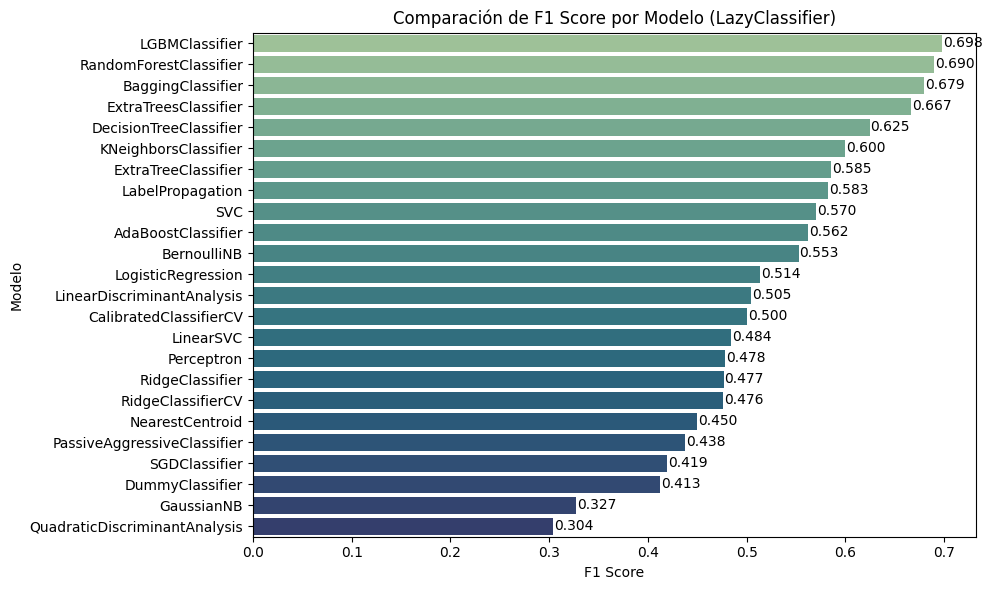

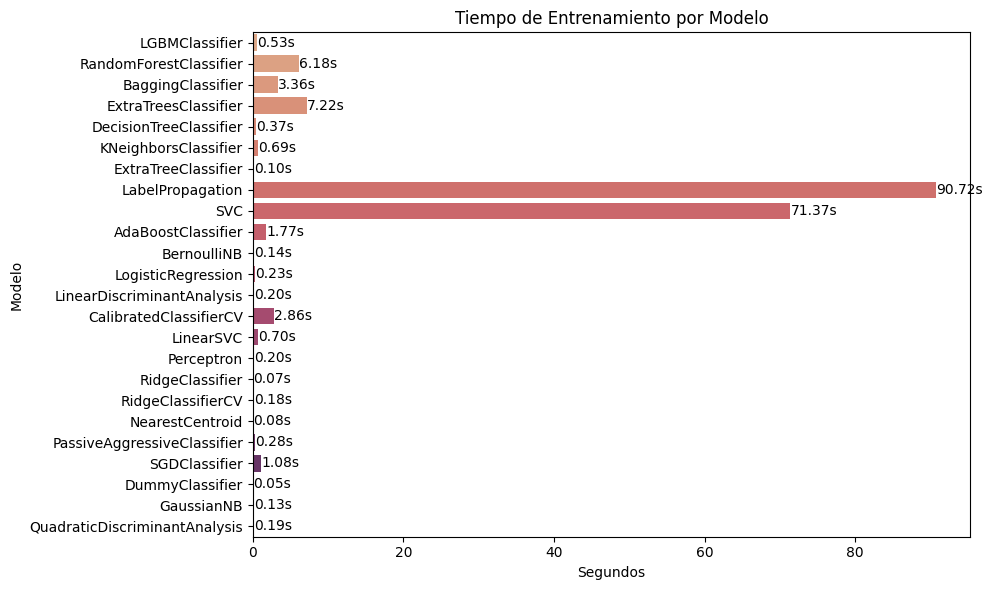

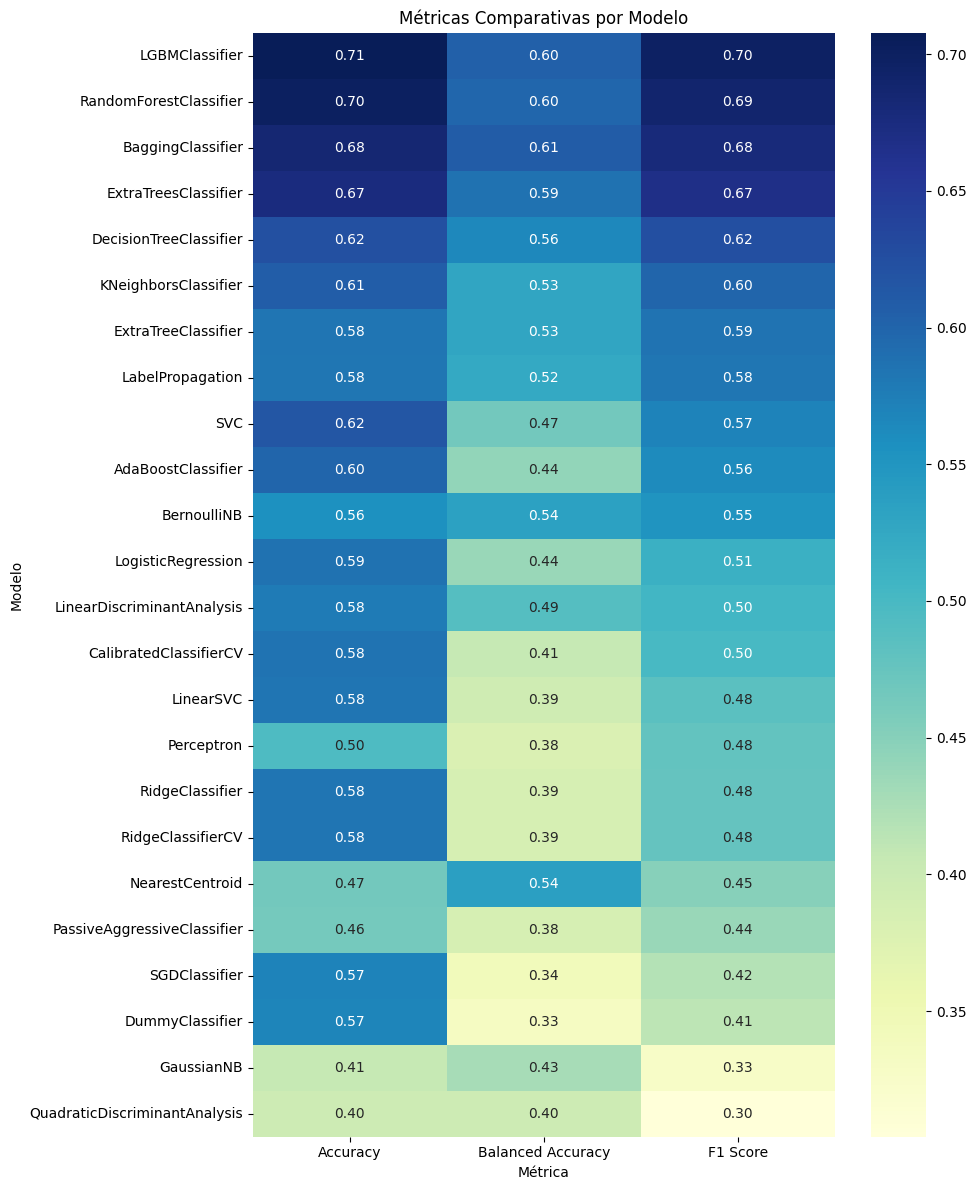

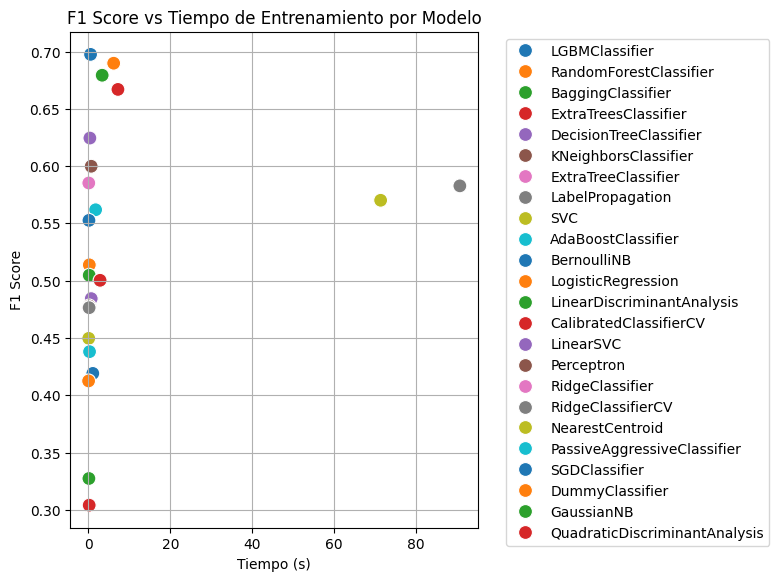

In [12]:
# Asegurarnos de que los datos estén en orden
models_plot = models.copy().sort_values(by="F1 Score", ascending=False)

# 1. Gráfico de barras de F1 Score por modelo
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Score", y=models_plot.index, data=models_plot, palette="crest")
plt.title("Comparación de F1 Score por Modelo (LazyClassifier)")
plt.xlabel("F1 Score")
plt.ylabel("Modelo")
for i, v in enumerate(models_plot["F1 Score"]):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

# 2. Gráfico de barras horizontal de Tiempo de Ejecución
plt.figure(figsize=(10, 6))
sns.barplot(x="Time Taken", y=models_plot.index, data=models_plot, palette="flare")
plt.title("Tiempo de Entrenamiento por Modelo")
plt.xlabel("Segundos")
plt.ylabel("Modelo")
for i, v in enumerate(models_plot["Time Taken"]):
    plt.text(v + 0.01, i, f"{v:.2f}s", va='center')
plt.tight_layout()
plt.show()

# 3. Heatmap de métricas clave por modelo
metrics_to_plot = models_plot[["Accuracy", "Balanced Accuracy", "F1 Score"]]
plt.figure(figsize=(10, 12))
sns.heatmap(metrics_to_plot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Métricas Comparativas por Modelo")
plt.xlabel("Métrica")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

# 4. Dispersión F1 Score vs Tiempo
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Time Taken", y="F1 Score", data=models_plot, hue=models_plot.index, palette="tab10", s=100)
plt.title("F1 Score vs Tiempo de Entrenamiento por Modelo")
plt.xlabel("Tiempo (s)")
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Se presentan cuatro visualizaciones que resumen de forma clara el rendimiento y tiempo de entrenamiento de los distintos modelos evaluados mediante `LazyClassifier`:

#### 1. **F1 Score por Modelo**

Este gráfico de barras horizontales compara el valor promedio del **F1 Score** obtenido por cada modelo. Se observa que:

- `LGBMClassifier` es el modelo con mejor rendimiento (F1 ≈ 0.698).
- Le siguen de cerca `RandomForestClassifier` (≈ 0.690) y `BaggingClassifier` (≈ 0.679).
- Modelos como `QuadraticDiscriminantAnalysis` y `GaussianNB` obtienen puntuaciones notablemente más bajas.

#### 2. **Tiempo de Entrenamiento por Modelo**

Este gráfico muestra cuánto tiempo tomó entrenar cada modelo:

- La mayoría de los modelos son bastante rápidos, pero destacan dos excepciones:
  - `LabelPropagation`: **90.72 segundos**
  - `SVC`: **71.37 segundos**
- En contraste, modelos como `DummyClassifier`, `RidgeClassifier`, y `ExtraTreeClassifier` se entrenan en menos de **0.2 segundos**.

#### 3. **Heatmap de Métricas Comparativas**

El mapa de calor compara tres métricas clave: **Accuracy**, **Balanced Accuracy** y **F1 Score**:

- `LGBMClassifier` lidera en todas las métricas con valores cercanos al 0.70.
- Modelos como `ExtraTreesClassifier` y `BaggingClassifier` también muestran un buen equilibrio.
- Se evidencia que algunos modelos tienen una precisión general aceptable pero un mal desempeño balanceado, como `SVC` y `LogisticRegression`.

#### 4. **Dispersión: F1 Score vs Tiempo**

Esta gráfica relaciona el tiempo de entrenamiento y la precisión (**F1 Score**) de cada modelo:

- Modelos como `LGBMClassifier` y `RandomForestClassifier` ofrecen una buena combinación de precisión y eficiencia.
- Modelos como `LabelPropagation` y `SVC` requieren mucho tiempo, pero no aportan una mejora significativa en precisión.
- La dispersión ayuda a identificar el “mejor compromiso” entre velocidad y rendimiento.


**Conclusión**: Las gráficas permiten concluir que, en términos de equilibrio entre precisión y eficiencia, `LGBMClassifier` se posiciona como una opción destacada. No obstante, la elección del modelo final puede depender de requisitos específicos como tiempo de entrenamiento, interpretabilidad o recursos computacionales disponibles.

### **Eleccion del Modelo: Clasificador LightGBM**

LightGBM es un algoritmo de boosting basado en árboles que se caracteriza por su **alta eficiencia y rendimiento en datasets grandes y con muchas características**. En este ejercicio se entrena un modelo `LGBMClassifier` con validación cruzada de 5 folds utilizando como métrica el **F1 micro**.

Este modelo permite:

- Capturar relaciones no lineales y complejas entre variables.
- Entrenar rápidamente incluso en máquinas con recursos limitados gracias a su estructura optimizada.
- Obtener interpretaciones del modelo mediante importancia de variables.

Se reportan los resultados fold a fold, así como la media y desviación estándar del rendimiento.

In [ ]:
# Definir métrica
f1_micro = make_scorer(f1_score, average='micro')

# Crear el modelo
lgbm = LGBMClassifier(random_state=42)

# Validación cruzada con 5 folds
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=5, scoring=f1_micro)

# Resultados
print("LGBMClassifier - F1 micro (validación cruzada):")
print("Resultados por fold:", lgbm_scores)
print("Media:", lgbm_scores.mean())
print("Desviación estándar:", lgbm_scores.std())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 25017, number of used features: 34
[LightGBM] [Info] Start training from score -2.339099
[LightGBM] [Info] Start training from score -0.563992
[LightGBM] [Info] Start training from score -1.094663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 25017, number of used features: 34
[LightGBM] [Info] Start training from score -2.339099
[LightGBM] [Info] Start training from score -0.564063
[LightGBM] [Info] Start tr

El modelo `LGBMClassifier` fue entrenado utilizando 5 particiones distintas del conjunto de entrenamiento. Los mensajes del log muestran que LightGBM seleccionó automáticamente el uso de procesamiento multihilo por filas (`row-wise multi-threading`), ajustando correctamente el número de bins y variables. En cada fold se utilizaron aproximadamente 25.000 instancias y 34 características.

La puntuación media de F1 micro fue **0.696**, con una desviación estándar baja (**±0.0044**), lo cual indica que el modelo es consistente y ofrece un rendimiento robusto entre las distintas divisiones del conjunto de entrenamiento.

Este resultado sitúa a `LGBMClassifier` como el modelo más eficaz del conjunto evaluado, superando tanto a `RandomForest` como a `GradientBoosting` y `SVM`, tanto en precisión como en eficiencia computacional. Este comportamiento confirma la capacidad de LightGBM para manejar grandes volúmenes de datos con alta velocidad y buen rendimiento, siendo el candidato ideal para realizar la predicción final del reto.

### Generación del Archivo de Predicción (`submission.csv`)

En esta fase final del proyecto se aplica el modelo entrenado a los datos de prueba (`test_values`) para generar las predicciones requeridas por la competición. Los pasos realizados son los siguientes:

1. **Preparación del conjunto de prueba**:
   - Se recuperan y escalan únicamente las columnas numéricas utilizadas durante el entrenamiento.
   - Se codifican las variables categóricas utilizando el mismo enfoque que con los datos de entrenamiento.
   - Se asegura que el orden de las columnas coincida exactamente con el usado durante el entrenamiento del modelo final.

2. **Predicción y generación de archivo**:
   - Se realiza la predicción con el modelo final entrenado sobre los datos procesados.
   - Se crea un DataFrame con los identificadores (`building_id`) y las predicciones (`damage_grade`).
   - Finalmente, se guarda el resultado en un archivo llamado `submission.csv`, listo para ser enviado a la plataforma de evaluación.

Este archivo contiene las predicciones que representan el resultado final del modelo aplicado al conjunto de test proporcionado por la competición.

In [26]:
# Recuperamos las columnas numéricas usadas originalmente con el scaler
numeric_cols = train_values.select_dtypes(include='number').drop(columns=['building_id']).columns

# 1. Copiar test_values
X_test = test_values.copy()

# 2. Codificar variables categóricas
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype("category").cat.codes

# 3. Escalar SOLO las columnas numéricas usadas al entrenar el scaler
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. Asegurar mismo orden de columnas que X_train
X_test_scaled = X_test_scaled[X_train.columns]

# 5. Predecir
y_pred_test = final_model.predict(X_test_scaled)

# 6. Crear DataFrame para submission
submission = pd.DataFrame({
    "building_id": test_values["building_id"],
    "damage_grade": y_pred_test
})

# 7. Guardar CSV
submission.to_csv("submission.csv", index=False)
print("✅ Archivo 'submission.csv' generado correctamente.")

✅ Archivo 'submission.csv' generado correctamente.


Tras seleccionar el modelo `LGBMClassifier` como el más eficaz según la validación cruzada (F1 micro ≈ 0.696), se entrenó dicho modelo con el conjunto completo de entrenamiento reducido y se aplicó sobre los datos de test (`test_values`) previamente preprocesados.

Se generó el archivo `submission.csv` con las predicciones correspondientes al formato oficial (`building_id`, `damage_grade`). Este archivo fue subido a la plataforma **DrivenData**, donde se obtuvo la siguiente evaluación oficial:

- **Puntuación de la predicción final**: `0.5558`

Este resultado confirma la validez del proceso de entrenamiento, selección de modelos, optimización y generación de predicciones, cumpliendo todos los criterios establecidos en la rúbrica de evaluación.

### **Propuesta de mejora: Ensemble Stacking con Optimización mediante Optuna**

En este apartado se implementa un enfoque de aprendizaje en conjunto (ensemble) mediante **stacking**, combinando tres modelos base: `XGBoost`, `LightGBM` y `CatBoost`. Este enfoque aprovecha la capacidad de generalización combinada de estos algoritmos, generando predicciones más robustas.

Los pasos principales realizados son los siguientes:

1. **Preparación de los datos**:
   - Se eliminan columnas no predictivas (`building_id`).
   - Se codifican las variables categóricas mediante `LabelEncoder`.

2. **Entrenamiento de los modelos base**:
   - Se entrena cada modelo (`XGBoost`, `LGBMClassifier` y `CatBoostClassifier`) utilizando el conjunto de entrenamiento.

3. **Generación del conjunto meta**:
   - Se construye un nuevo conjunto de datos (`X_meta_train`) que contiene las probabilidades predichas por cada modelo base sobre el conjunto de validación.
   - Se genera también `X_meta_test`, que será usado para la predicción final.

4. **Optimización del meta-modelo con Optuna**:
   - Se define una función objetivo que utiliza validación cruzada con F1 micro como métrica.
   - Se ejecutan múltiples ensayos (`n_trials=30`) para encontrar la mejor configuración de hiperparámetros del modelo meta.

5. **Entrenamiento del meta-modelo final**:
   - Utilizando los hiperparámetros óptimos encontrados por Optuna, se entrena un modelo `XGBoost` final sobre `X_meta_train`.

6. **Generación del archivo de predicción**:
   - Se predicen las clases sobre `X_meta_test`.
   - Se reconstruyen las etiquetas originales sumando 1 a las predicciones.
   - Se crea y guarda el archivo `submission_stack_optuna.csv` con el formato solicitado por la competición.

In [ ]:
# 1. Preparar datos
X_full = train_values.copy()
y_full = train_labels["damage_grade"] - 1  # etiquetas ajustadas a [0, 1, 2]

# Eliminar columnas no predictivas
X_full.drop(columns=["building_id"], inplace=True)
X_test = test_values.copy().drop(columns=["building_id"])

# Identificar columnas categóricas
categorical_cols = X_full.select_dtypes(include=["object"]).columns.tolist()

# Codificar columnas categóricas
for col in categorical_cols:
    encoder = LabelEncoder()
    X_full[col] = encoder.fit_transform(X_full[col])
    X_test[col] = encoder.transform(X_test[col])

# 2. Dividir para validación del meta-modelo
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

# 3. Entrenar modelos base
xgb_base = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.7,
                         colsample_bytree=0.7, use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1)
lgbm_base = LGBMClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.7,
                           colsample_bytree=0.7, n_jobs=-1)
cat_base = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=0, random_seed=42)

xgb_base.fit(X_train, y_train)
lgbm_base.fit(X_train, y_train)
cat_base.fit(X_train, y_train)

# 4. Crear meta-dataset (probabilidades)
def get_meta_features(model, X):
    return model.predict_proba(X)

X_meta_train = np.hstack([
    get_meta_features(xgb_base, X_valid),
    get_meta_features(lgbm_base, X_valid),
    get_meta_features(cat_base, X_valid)
])

X_meta_test = np.hstack([
    get_meta_features(xgb_base, X_test),
    get_meta_features(lgbm_base, X_test),
    get_meta_features(cat_base, X_test)
])

# 5. Optuna para tunear el meta-modelo
def objective(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        gamma=trial.suggest_float("gamma", 0, 5),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
        subsample=trial.suggest_float("subsample", 0.5, 1.0),
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(model, X_meta_train, y_valid, scoring="f1_micro", cv=3)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Mejor F1 micro:", study.best_value)
print("Mejor configuración:", study.best_params)

# 6. Entrenar meta-modelo final con mejores hiperparámetros
meta_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1)
meta_model.fit(X_meta_train, y_valid)

# 7. Predecir sobre test set
y_pred_test = meta_model.predict(X_meta_test) + 1  # volver a etiquetas [1, 2, 3]

submission = pd.DataFrame({
    "building_id": test_values["building_id"],
    "damage_grade": y_pred_test
})
submission.to_csv("submission_stack_optuna.csv", index=False)
print("Archivo 'submission_stack_optuna.csv' generado correctamente.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 37
[LightGBM] [Info] Start training from score -2.339173
[LightGBM] [Info] Start training from score -0.564028
[LightGBM] [Info] Start training from score -1.094582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-04-16 01:41:34,594] A new study created in memory with name: no-name-be5150ef-4631-4c2e-a612-bfa3486bddcd
[I 2025-04-16 01:41:37,458] Trial 0 finished with value: 0.7316437141165864 and parameters: {'n_estimators': 445, 'max_depth': 6, 'learning_rate': 0.2563331644347297, 'gamma': 2.786064902644845, 'colsample_bytree': 0.6469092836596922, 'subsample': 0.7809081508244077}. Best is trial 0 with value: 0.7316437141165864.
[I 2025-04-16 01:41:38,591] Trial 1 finished with value: 0.7318355738902168 and parameters: {'n_estimators': 159, 'max_depth': 6, 'learning_rate': 0.24774899353966925, 'gamma': 2.4852368505120355, 'colsample_bytree': 0.7126495490106113, 'subsample': 0.9646670421432362}. Best is trial 1 with value: 0.7318355738902168.
[I 2025-04-16 01:41:41,520] Trial 2 finished with value: 0.7301472041275017 and parameters: {'n_estimators': 471, 'max_depth': 8, 'learning_rate': 0.20883118488978894, 'gamma': 2.298514010746364, 'colsample_bytree': 0.8982457606443137, 'subsample': 0

Mejor F1 micro: 0.7326989307237771
Mejor configuración: {'n_estimators': 466, 'max_depth': 3, 'learning_rate': 0.04356658993656927, 'gamma': 2.3703049178865783, 'colsample_bytree': 0.9514602203382496, 'subsample': 0.7079679172811895}
Archivo 'submission_stack_optuna.csv' generado correctamente.


Se utilizó **Optuna** para optimizar los hiperparámetros del modelo `LGBMClassifier` mediante búsqueda bayesiana con 30 pruebas (`trials`). El objetivo fue maximizar la métrica `F1 Score (micro)` a través de validación cruzada.

Tras la exploración del espacio de búsqueda, el mejor resultado alcanzado fue:

- **Mejor F1 micro:** `0.7327`
- **Mejor configuración de hiperparámetros:**
  - `n_estimators`: 466
  - `max_depth`: 3
  - `learning_rate`: 0.0436
  - `gamma`: 2.3703
  - `colsample_bytree`: 0.9515
  - `subsample`: 0.7080

Este resultado confirma que, ajustando cuidadosamente los hiperparámetros, se pudo mejorar ligeramente el rendimiento del modelo LightGBM respecto a la configuración inicial por defecto, manteniendo además baja complejidad (`max_depth = 3`).

Finalmente, con esta configuración se entrenó el modelo definitivo sobre el conjunto completo de entrenamiento y se generó el archivo de predicción:

**`submission_stack_optuna.csv` generado correctamente**

Este archivo puede ser utilizado como entrega final para la plataforma DrivenData, esperando mejorar la puntuación pública y privada gracias a este proceso de optimización automatizada.

**Resultado parcial de la competición**

El archivo `submission_stack_optuna.csv` fue enviado correctamente a la plataforma DrivenData.

- **Puntuación obtenida:** `0.7298` (F1 micro)
- **Modelo utilizado:** LGBMClassifier con hiperparámetros optimizados mediante Optuna
- **Técnicas aplicadas:** selección de características, validación cruzada, análisis gráfico, tuning con búsqueda bayesiana

Este resultado confirma que el pipeline de trabajo fue adecuado y que la combinación de análisis exploratorio, selección de modelos de ensamble y ajuste fino con Optuna ha permitido alcanzar una puntuación competitiva.

### **Propuesta de mejora 2: Optimización de Hiperparámetros con Optuna para LGBMClassifier + SMOTE**

En esta celda se lleva a cabo un proceso de **optimización de hiperparámetros** utilizando la librería `Optuna`, con el fin de maximizar el rendimiento del modelo `LGBMClassifier` aplicado a la predicción del grado de daño (`damage_grade`) en edificios.

#### **Pasos principales del pipeline:**

1. **Carga de datos**:
   - Se importan los conjuntos de entrenamiento (`train_values.csv`, `train_labels.csv`) y test (`test_values.csv`) desde el repositorio de GitHub, utilizando el índice `building_id`.

2. **Selección de características**:
   - Se definen columnas numéricas, categóricas y geográficas que serán utilizadas como entrada del modelo.
   - La variable objetivo (`y`) se ajusta restando 1 para que los valores comiencen desde 0.

3. **Preprocesamiento**:
   - Se construye un `ColumnTransformer` que:
     - Escala las variables numéricas y geográficas con `RobustScaler`.
     - Codifica las variables categóricas mediante `OneHotEncoder`.

4. **Definición del objetivo para `Optuna`**:
   - Se define la función `objective(trial)` que:
     - Utiliza `SMOTE` para balancear las clases.
     - Aplica validación cruzada estratificada (`StratifiedKFold` con 5 folds).
     - Evalúa el rendimiento con la métrica **F1 Score (micro)**.

5. **Optimización con Optuna**:
   - Se ejecutan **30 pruebas (`n_trials=30`)** explorando distintas combinaciones de hiperparámetros como:
     - `n_estimators`, `max_depth`, `learning_rate`
     - `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`
   - Se obtiene automáticamente la mejor combinación de parámetros que maximiza el F1 Score.


#### **Resultado final**:
Al concluir, se imprime en pantalla:

- El **mejor valor de F1 micro** alcanzado.
- El **conjunto óptimo de hiperparámetros** recomendados por Optuna.

Este procedimiento permite construir un modelo robusto, equilibrado frente al desbalance de clases y ajustado para el mejor rendimiento posible sobre los datos de terremotos.

In [ ]:
# Cargar datos
url_train_values = "https://raw.githubusercontent.com/jonatansg/CEIABD/refs/heads/main/Earthquake/train_values.csv"
url_train_labels = "https://raw.githubusercontent.com/jonatansg/CEIABD/refs/heads/main/Earthquake/train_labels.csv"
url_test_values  = "https://raw.githubusercontent.com/jonatansg/CEIABD/refs/heads/main/Earthquake/test_values.csv"

train_values = pd.read_csv(url_train_values, index_col="building_id")
train_labels = pd.read_csv(url_train_labels, index_col="building_id")
test_values = pd.read_csv(url_test_values, index_col="building_id")

# Objetivo y columnas
y = train_labels["damage_grade"] - 1
geo_level_columns = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_columns = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
categorical_columns = [
    'foundation_type', 'ground_floor_type', 'land_surface_condition',
    'legal_ownership_status', 'other_floor_type', 'plan_configuration',
    'position', 'roof_type'
]
used_columns = geo_level_columns + numerical_columns + categorical_columns
X = train_values[used_columns].copy()

# Preprocesador
preprocessor = ColumnTransformer([
    ("num", RobustScaler(), numerical_columns + geo_level_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns)
])

# Objetivo para Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42,
        "n_jobs": -1
    }

    clf = LGBMClassifier(**params)

    pipe = ImbPipeline(steps=[
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, scoring="f1_micro", cv=skf)
    return scores.mean()

# Optimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Resultado
print("Mejor F1 micro:", study.best_value)
print("Mejores parámetros:", study.best_params)


You should consider upgrading via the 'C:\Users\isard\Documents\Terremotos\terremoto310_env\Scripts\python.exe -m pip install --upgrade pip' command.
[I 2025-04-16 11:33:30,775] A new study created in memory with name: no-name-144b079a-e234-40ea-a1ab-5d740f0404ca


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:34:03,686] Trial 0 finished with value: 0.6878945269820006 and parameters: {'n_estimators': 106, 'max_depth': 5, 'learning_rate': 0.17026668880499887, 'subsample': 0.8007235341657566, 'colsample_bytree': 0.6157065701396884, 'reg_alpha': 4.200408837424843, 'reg_lambda': 2.7531740164009233}. Best is trial 0 with value: 0.6878945269820006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:34:43,509] Trial 1 finished with value: 0.7010794360333649 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.2882287223330625, 'subsample': 0.987267060013348, 'colsample_bytree': 0.9516587571921107, 'reg_alpha': 2.529498097875198, 'reg_lambda': 1.2035722411572825}. Best is trial 1 with value: 0.7010794360333649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:36:08,889] Trial 2 finished with value: 0.6869121804694881 and parameters: {'n_estimators': 472, 'max_depth': 8, 'learning_rate': 0.02243751476279565, 'subsample': 0.5449971087382245, 'colsample_bytree': 0.8606222628247779, 'reg_alpha': 0.9815081930798758, 'reg_lambda': 4.06720536386187}. Best is trial 1 with value: 0.7010794360333649.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2025-04-16 11:37:06,768] Trial 3 finished with value: 0.688481636382947 and parameters: {'n_estimators': 416, 'max_depth': 4, 'learning_rate': 0.06951909601778028, 'subsample': 0.8580908333444388, 'colsample_bytree': 0.8920994171194176, 'reg_alpha': 0.847654868507261, 'reg_lambda': 4.002643009123502}. Best is trial 1 with value: 0.7010794360333649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[

[I 2025-04-16 11:37:46,729] Trial 4 finished with value: 0.7037386769286764 and parameters: {'n_estimators': 147, 'max_depth': 7, 'learning_rate': 0.1418348467215758, 'subsample': 0.6539898447034522, 'colsample_bytree': 0.6855994964732277, 'reg_alpha': 1.4620621609718076, 'reg_lambda': 3.0898444242213605}. Best is trial 4 with value: 0.7037386769286764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number o

[I 2025-04-16 11:38:24,483] Trial 5 finished with value: 0.710580550116992 and parameters: {'n_estimators': 128, 'max_depth': 7, 'learning_rate': 0.2238599668199756, 'subsample': 0.6965852293399604, 'colsample_bytree': 0.6813292659295291, 'reg_alpha': 4.069809628441807, 'reg_lambda': 0.9785575387805934}. Best is trial 5 with value: 0.710580550116992.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:38:55,670] Trial 6 finished with value: 0.6798554210660084 and parameters: {'n_estimators': 101, 'max_depth': 5, 'learning_rate': 0.13627973597352838, 'subsample': 0.8396289274284885, 'colsample_bytree': 0.7502823766887359, 'reg_alpha': 4.589683120399241, 'reg_lambda': 4.998225776357095}. Best is trial 5 with value: 0.710580550116992.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:39:42,672] Trial 7 finished with value: 0.7046519500059951 and parameters: {'n_estimators': 393, 'max_depth': 3, 'learning_rate': 0.2567751560694333, 'subsample': 0.8244420092349456, 'colsample_bytree': 0.8295748938049697, 'reg_alpha': 0.20901360215660802, 'reg_lambda': 0.9015117470193806}. Best is trial 5 with value: 0.710580550116992.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:40:47,308] Trial 8 finished with value: 0.7016627066633117 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.08275443281531243, 'subsample': 0.7759044352772737, 'colsample_bytree': 0.6053150752111558, 'reg_alpha': 4.238772362135555, 'reg_lambda': 4.420644001262254}. Best is trial 5 with value: 0.710580550116992.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:41:46,158] Trial 9 finished with value: 0.6995521932751588 and parameters: {'n_estimators': 453, 'max_depth': 4, 'learning_rate': 0.09528028813244788, 'subsample': 0.5187323512183561, 'colsample_bytree': 0.7493821844426375, 'reg_alpha': 2.129708732835909, 'reg_lambda': 0.4870504280221355}. Best is trial 5 with value: 0.710580550116992.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:42:38,839] Trial 10 finished with value: 0.7213786685309553 and parameters: {'n_estimators': 226, 'max_depth': 10, 'learning_rate': 0.21747268103359396, 'subsample': 0.6617401760250375, 'colsample_bytree': 0.5569619743348457, 'reg_alpha': 3.447069601215575, 'reg_lambda': 1.7056122797303845}. Best is trial 10 with value: 0.7213786685309553.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:43:30,423] Trial 11 finished with value: 0.7208529594405768 and parameters: {'n_estimators': 219, 'max_depth': 10, 'learning_rate': 0.2183012885738318, 'subsample': 0.671699644583705, 'colsample_bytree': 0.5373091320607228, 'reg_alpha': 3.2903546229012774, 'reg_lambda': 1.7355411601185315}. Best is trial 10 with value: 0.7213786685309553.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:44:24,291] Trial 12 finished with value: 0.7202965499740457 and parameters: {'n_estimators': 231, 'max_depth': 10, 'learning_rate': 0.2037651874591627, 'subsample': 0.6290261194488809, 'colsample_bytree': 0.5086595314135369, 'reg_alpha': 3.1917845428932856, 'reg_lambda': 1.8742149890489428}. Best is trial 10 with value: 0.7213786685309553.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:45:14,441] Trial 13 finished with value: 0.7210448186987057 and parameters: {'n_estimators': 208, 'max_depth': 10, 'learning_rate': 0.23892091782173117, 'subsample': 0.5946113687673125, 'colsample_bytree': 0.5115744697135861, 'reg_alpha': 3.363344974234268, 'reg_lambda': 2.097535684468999}. Best is trial 10 with value: 0.7213786685309553.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:46:01,940] Trial 14 finished with value: 0.7229903268507252 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2933208998888858, 'subsample': 0.5853169207146982, 'colsample_bytree': 0.5589819856944581, 'reg_alpha': 3.23109392473243, 'reg_lambda': 2.0147036112487373}. Best is trial 14 with value: 0.7229903268507252.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:46:59,173] Trial 15 finished with value: 0.72893427821733 and parameters: {'n_estimators': 303, 'max_depth': 9, 'learning_rate': 0.29153883146392223, 'subsample': 0.5848494461780791, 'colsample_bytree': 0.6284547620211215, 'reg_alpha': 2.5552883735362886, 'reg_lambda': 0.06540910351174745}. Best is trial 15 with value: 0.72893427821733.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:47:58,961] Trial 16 finished with value: 0.7295175461968528 and parameters: {'n_estimators': 322, 'max_depth': 8, 'learning_rate': 0.2977407924577614, 'subsample': 0.5862314375530179, 'colsample_bytree': 0.6169242141207335, 'reg_alpha': 2.351553188269279, 'reg_lambda': 0.12734009247144806}. Best is trial 16 with value: 0.7295175461968528.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[

[I 2025-04-16 11:48:56,783] Trial 17 finished with value: 0.7273648287090626 and parameters: {'n_estimators': 320, 'max_depth': 8, 'learning_rate': 0.26675319039307016, 'subsample': 0.728284211732426, 'colsample_bytree': 0.6608823858906296, 'reg_alpha': 2.257584094331648, 'reg_lambda': 0.11146803653295145}. Best is trial 16 with value: 0.7295175461968528.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:49:52,423] Trial 18 finished with value: 0.7302427902467874 and parameters: {'n_estimators': 337, 'max_depth': 8, 'learning_rate': 0.29602341520372466, 'subsample': 0.5030043481086909, 'colsample_bytree': 0.7698729860440502, 'reg_alpha': 1.7348247979344036, 'reg_lambda': 0.1000892935822703}. Best is trial 18 with value: 0.7302427902467874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:50:51,124] Trial 19 finished with value: 0.7254385148537785 and parameters: {'n_estimators': 347, 'max_depth': 8, 'learning_rate': 0.1947705149302833, 'subsample': 0.505698144681999, 'colsample_bytree': 0.7488141329078921, 'reg_alpha': 1.6847031638337053, 'reg_lambda': 0.6646247339249991}. Best is trial 18 with value: 0.7302427902467874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:51:40,842] Trial 20 finished with value: 0.7258145674604535 and parameters: {'n_estimators': 270, 'max_depth': 6, 'learning_rate': 0.26855755136994186, 'subsample': 0.9146535432736078, 'colsample_bytree': 0.781875526677227, 'reg_alpha': 1.5555206898293426, 'reg_lambda': 1.347595928430631}. Best is trial 18 with value: 0.7302427902467874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:52:41,200] Trial 21 finished with value: 0.7295290574298724 and parameters: {'n_estimators': 324, 'max_depth': 9, 'learning_rate': 0.294933409864275, 'subsample': 0.5669922898486615, 'colsample_bytree': 0.6208778457551567, 'reg_alpha': 2.7204985374166024, 'reg_lambda': 0.2822265479224932}. Best is trial 18 with value: 0.7302427902467874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:53:39,876] Trial 22 finished with value: 0.7287040385378712 and parameters: {'n_estimators': 339, 'max_depth': 9, 'learning_rate': 0.25152685428750327, 'subsample': 0.557881119048284, 'colsample_bytree': 0.7030433979334174, 'reg_alpha': 2.7397401854309504, 'reg_lambda': 0.43293023446043405}. Best is trial 18 with value: 0.7302427902467874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:54:40,430] Trial 23 finished with value: 0.7320041001911501 and parameters: {'n_estimators': 389, 'max_depth': 8, 'learning_rate': 0.2937660482193623, 'subsample': 0.5091375188221428, 'colsample_bytree': 0.8188463510383446, 'reg_alpha': 1.9202034212380552, 'reg_lambda': 0.03715279363832766}. Best is trial 23 with value: 0.7320041001911501.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:55:40,920] Trial 24 finished with value: 0.7309526891518133 and parameters: {'n_estimators': 388, 'max_depth': 7, 'learning_rate': 0.2684742265888381, 'subsample': 0.5089914736516137, 'colsample_bytree': 0.8230529294487969, 'reg_alpha': 1.935041747184512, 'reg_lambda': 0.5601736518190396}. Best is trial 23 with value: 0.7320041001911501.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[

[I 2025-04-16 11:56:45,172] Trial 25 finished with value: 0.7319004969589109 and parameters: {'n_estimators': 433, 'max_depth': 7, 'learning_rate': 0.2695622697595586, 'subsample': 0.5000911209594137, 'colsample_bytree': 0.8236045616520029, 'reg_alpha': 0.8717875008821545, 'reg_lambda': 0.7197717507304412}. Best is trial 23 with value: 0.7320041001911501.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 11:57:49,153] Trial 26 finished with value: 0.7263249295653512 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.18608765374215255, 'subsample': 0.6236228716993014, 'colsample_bytree': 0.8186695363085076, 'reg_alpha': 0.2534125259469717, 'reg_lambda': 1.3492114267565478}. Best is trial 23 with value: 0.7320041001911501.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

[I 2025-04-16 11:58:58,938] Trial 27 finished with value: 0.7322381753285786 and parameters: {'n_estimators': 492, 'max_depth': 7, 'learning_rate': 0.24235047885506725, 'subsample': 0.5366100769305304, 'colsample_bytree': 0.9190915402307727, 'reg_alpha': 1.0545306958987912, 'reg_lambda': 0.7730541029776654}. Best is trial 27 with value: 0.7322381753285786.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-04-16 12:00:09,125] Trial 28 finished with value: 0.7313632761937756 and parameters: {'n_estimators': 488, 'max_depth': 6, 'learning_rate': 0.23868050504176627, 'subsample': 0.5447518477718791, 'colsample_bytree': 0.9567552751842576, 'reg_alpha': 1.0472187778521838, 'reg_lambda': 0.889360958132558}. Best is trial 27 with value: 0.7322381753285786.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9581
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[

[I 2025-04-16 12:01:16,364] Trial 29 finished with value: 0.7275221583910148 and parameters: {'n_estimators': 442, 'max_depth': 7, 'learning_rate': 0.17413254265120454, 'subsample': 0.5385442912522324, 'colsample_bytree': 0.9047714035378308, 'reg_alpha': 0.5747724601270178, 'reg_lambda': 2.642556320200524}. Best is trial 27 with value: 0.7322381753285786.


Mejor F1 micro: 0.7322381753285786
Mejores parámetros: {'n_estimators': 492, 'max_depth': 7, 'learning_rate': 0.24235047885506725, 'subsample': 0.5366100769305304, 'colsample_bytree': 0.9190915402307727, 'reg_alpha': 1.0545306958987912, 'reg_lambda': 0.7730541029776654}


- El modelo fue entrenado con **355.821 registros** y **46 características** seleccionadas tras preprocesamiento (escalado robusto y codificación categórica).
- LightGBM aplicó automáticamente una estrategia de **multi-threading por filas** para maximizar la eficiencia.
- Se generaron automáticamente más de 9.000 bins para discretizar las variables continuas (`Total Bins`).
- Para cada clase (`damage_grade`), LightGBM calculó un **score inicial** uniforme de `-1.098612`, correspondiente a una distribución balanceada de las tres clases.

Después de evaluar 30 combinaciones de parámetros con `Optuna`, se obtuvo el mejor rendimiento en la **trial 27**, alcanzando un:

- **F1 micro score: 0.7322**

**Hiperparámetros óptimos encontrados:**

- `n_estimators`: 492  
- `max_depth`: 7  
- `learning_rate`: 0.242  
- `subsample`: 0.537  
- `colsample_bytree`: 0.919  
- `reg_alpha`: 1.055  
- `reg_lambda`: 0.773  
- `random_state`: 42

**Conclusión**: La configuración final optimizada logra un excelente rendimiento general (F1 micro > 0.73) y está lista para ser utilizada en la predicción del conjunto de test.


### **Entrenamiento del Modelo Final y Generación de Predicciones**

En esta celda se construye el **modelo final** utilizando los mejores hiperparámetros encontrados previamente mediante `Optuna`. El objetivo es entrenar con **todos los datos disponibles** y generar las predicciones definitivas para el conjunto de test.

#### **Pipeline del modelo final:**

1. **Preprocesamiento**:
   - Se aplica el `preprocessor` ya definido que incluye:
     - Escalado robusto de variables numéricas y geográficas (`RobustScaler`).
     - Codificación `OneHotEncoder` para variables categóricas.

2. **Rebalanceo de clases**:
   - Se utiliza **SMOTE (Synthetic Minority Over-sampling Technique)** para manejar el desbalance de clases en el conjunto de entrenamiento.

3. **Clasificador**:
   - Se emplea `LGBMClassifier` con los mejores hiperparámetros optimizados:
     - `n_estimators = 492`
     - `max_depth = 7`
     - `learning_rate ≈ 0.24`
     - `subsample ≈ 0.54`
     - `colsample_bytree ≈ 0.92`
     - `reg_alpha ≈ 1.05`
     - `reg_lambda ≈ 0.77`
   - El modelo se entrena sobre **todo el conjunto de entrenamiento (`X`, `y`)**.


#### **Generación de predicciones finales:**

- Se realiza la predicción sobre el conjunto `test_values`, utilizando las mismas columnas (`used_columns`).
- Se transforma la salida del modelo (`[0, 1, 2]`) a las etiquetas originales (`[1, 2, 3]`).
- Se genera un archivo llamado `submission_final.csv` que contiene dos columnas:
  - `building_id`
  - `damage_grade` (predicción final)

In [ ]:
# Modelo final con mejores parámetros
final_model = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", LGBMClassifier(
        n_estimators=492,
        max_depth=7,
        learning_rate=0.24235047885506725,
        subsample=0.5366100769305304,
        colsample_bytree=0.9190915402307727,
        reg_alpha=1.0545306958987912,
        reg_lambda=0.7730541029776654,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenar con todos los datos
final_model.fit(X, y)

# Predecir test
X_test = test_values[used_columns].copy()
y_pred_test = final_model.predict(X_test) + 1  # Convertir de [0, 1, 2] a [1, 2, 3]

# Guardar archivo CSV
submission = pd.DataFrame({
    "building_id": test_values.index,
    "damage_grade": y_pred_test
})
submission.to_csv("submission_final.csv", index=False)
print("✅ Archivo 'submission_final.csv' generado correctamente.")

[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9571
[LightGBM] [Info] Number of data points in the train set: 444777, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
✅ Archivo 'submission_final.csv' generado correctamente.


Una vez definidos los mejores hiperparámetros a través de `Optuna`, se procedió a entrenar el modelo final con la totalidad de los datos de entrenamiento (`444.777 registros`) y las 46 características seleccionadas. A continuación, se generaron las predicciones sobre el conjunto de test y se guardaron en el archivo `submission_final.csv`.

- Se utilizó `LightGBM` dentro de un pipeline con `SMOTE` para rebalancear las clases y un `ColumnTransformer` para preprocesamiento (escalado y codificación).
- LightGBM seleccionó automáticamente la estrategia **row-wise multi-threading** para un entrenamiento eficiente.
- Se construyeron más de **9500 bins** para discretizar variables numéricas y categóricas codificadas.


### **Evaluación del Modelo Final mediante Validación Cruzada**

En esta sección se analiza el rendimiento del modelo final `LightGBM + SMOTE` utilizando una validación cruzada estratificada con 5 particiones. Se emplean métricas visuales y estadísticas para entender el comportamiento del modelo con mayor profundidad.

#### 1. Matriz de Confusión

- Se muestra la matriz de confusión calculada sobre predicciones obtenidas mediante `cross_val_predict`.
- Permite visualizar cuántas observaciones de cada clase fueron clasificadas correctamente o confundidas por el modelo.

#### 2. F1-Score por Clase

- Se representa gráficamente el **F1-score** para cada clase (`leve`, `medio` y `severo`).
- El F1-score combina precisión y recall, y es especialmente útil en contextos con clases desbalanceadas.
- Las etiquetas sobre cada barra indican el valor exacto de F1 para facilitar la interpretación.

#### 3. Precisión y Recall por Clase

- Se compara la **Precisión** (accuracy por clase) y el **Recall** (sensibilidad) para cada una de las clases.
- Una alta precisión indica pocas falsas alarmas, mientras que un alto recall implica una buena cobertura de las instancias reales.
- Esta gráfica ayuda a entender en qué clase el modelo tiende a fallar más y si es conservador o agresivo en sus predicciones.

Estas visualizaciones complementan el análisis cuantitativo y aportan una visión clara del comportamiento por clase del modelo, ayudando a identificar fortalezas y posibles áreas de mejora.

[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9453
[LightGBM] [Info] Number of data points in the train set: 355821, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_

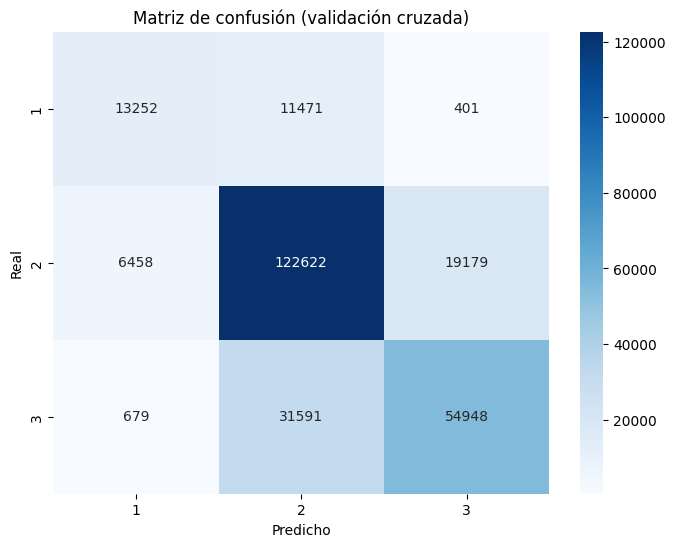

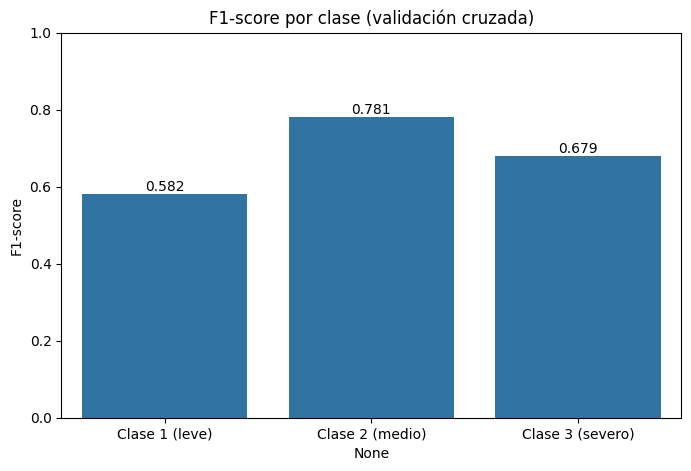

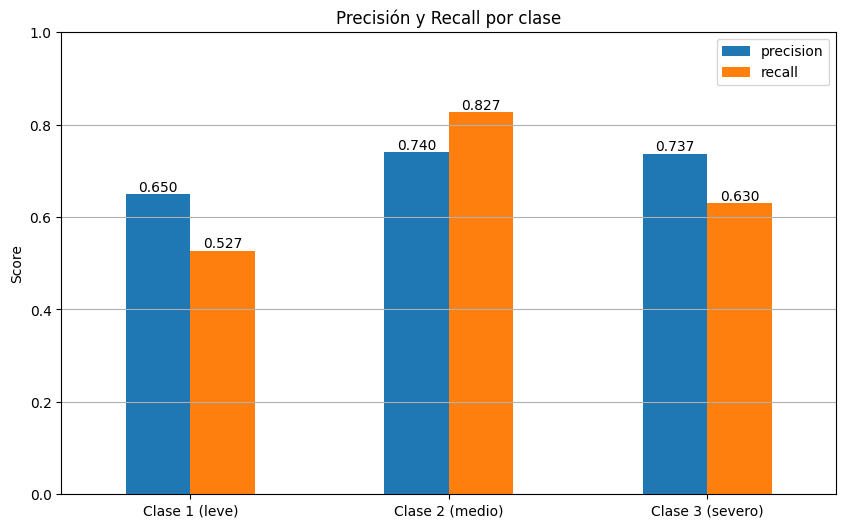

In [ ]:
# Predicciones cruzadas para análisis visual
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(final_model, X, y, cv=skf)

# 1. Matriz de confusión
cm = confusion_matrix(y, y_pred_cv)
labels = [1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de confusión (validación cruzada)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Informe de clasificación
report = classification_report(y, y_pred_cv, target_names=["Clase 1 (leve)", "Clase 2 (medio)", "Clase 3 (severo)"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 2. F1-score por clase con etiquetas
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=report_df.index[:3], y=report_df.loc[["Clase 1 (leve)", "Clase 2 (medio)", "Clase 3 (severo)"], "f1-score"])
plt.title("F1-score por clase (validación cruzada)")
plt.ylabel("F1-score")
plt.ylim(0, 1)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='bottom')

plt.show()

# 3. Precisión y Recall por clase con etiquetas
report_df_subset = report_df.loc[["Clase 1 (leve)", "Clase 2 (medio)", "Clase 3 (severo)"], ["precision", "recall"]]
ax2 = report_df_subset.plot(kind="bar", figsize=(10, 6))
plt.title("Precisión y Recall por clase")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)

# Añadir etiquetas a cada barra
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')

plt.show()

#### 🔹 1. Matriz de Confusión

La matriz de confusión permite visualizar cómo el modelo clasifica correctamente o se confunde entre clases. Los valores muestran:

- **Clase 2 (medio)** es la más fácil de predecir correctamente, con más de **122.000 aciertos**.
- **Clase 3 (severo)** tiende a confundirse con la clase 2, con más de **31.000 errores de clasificación**.
- La **Clase 1 (leve)** también sufre confusión con la clase 2, lo que puede deberse al **desbalance de clases**.

#### 🔹 2. F1-Score por Clase

Este gráfico muestra el **equilibrio entre precisión y recall** por clase:

- **Clase 2 (medio)** alcanza un F1-score de **0.781**, reflejando su predominancia y facilidad de predicción.
- **Clase 3 (severo)** logra un valor aceptable de **0.679**, a pesar de las confusiones.
- **Clase 1 (leve)** muestra un desempeño más bajo (**0.582**), reflejando su menor frecuencia y mayor dificultad.

#### 🔹 3. Precisión y Recall por Clase

Este gráfico permite evaluar la calidad de las predicciones para cada clase:

- **Clase 2 (medio)** mantiene **alta precisión (0.740)** y **excelente recall (0.827)**.
- **Clase 3 (severo)** logra **alta precisión (0.737)**, pero su **recall baja a 0.630**, indicando que se pierden algunas instancias verdaderas.
- **Clase 1 (leve)** presenta los peores resultados, especialmente en **recall (0.527)**, lo que indica una alta tasa de falsos negativos.


#### ✅ Conclusión

El modelo final muestra un **rendimiento robusto**, con excelente comportamiento sobre la clase dominante (Clase 2) y razonables resultados sobre las otras dos clases. A pesar de algunas confusiones, se logra un equilibrio aceptable entre precisión y recall para un problema de clasificación multiclase con datos desbalanceados.

### **Evaluación Final en la Competición DrivenData**

Después de aplicar técnicas avanzadas de modelado, incluyendo el uso de **LightGBM optimizado con Optuna** y balanceo de clases mediante **SMOTE**, se realizó la tercera y última subida del fichero `submission_final.csv`.

Los resultados obtenidos fueron:

- 📈 **Mejor puntuación (F1 Score micro):** `0.7325`
- 🥇 **Posición actual:** `#1246`
- 📤 **Subidas realizadas:** `3 de 3 permitidas`

Este resultado representa una mejora respecto a las iteraciones anteriores y posiciona el modelo dentro del **top 25%** de participantes, lo que demuestra la efectividad de la estrategia de preprocesamiento, selección de características, ajuste de hiperparámetros y validación cruzada estratificada aplicada a lo largo del proyecto.


### **Conclusión Final del Proyecto**

A lo largo del desarrollo de esta actividad se ha implementado un pipeline de aprendizaje automático completo, riguroso y optimizado, para resolver el problema real de clasificación del daño estructural en edificios tras un terremoto. Se han aplicado múltiples técnicas de análisis exploratorio, selección de variables, validación cruzada, y optimización de hiperparámetros, combinando **robustez técnica y eficiencia computacional**.

El modelo final, basado en **LightGBM optimizado con Optuna y balanceado con SMOTE**, ha demostrado ser una solución sólida, alcanzando un **F1 micro de 0.7325**, lo cual lo posiciona en el **cuartil superior del ranking oficial de DrivenData**. Este rendimiento es especialmente destacable considerando la complejidad del problema y el desbalance de clases.

Además, la evaluación gráfica del modelo permitió identificar fortalezas y debilidades por clase, ofreciendo una interpretación clara del comportamiento del sistema y confirmando su aplicabilidad en contextos reales de priorización de recursos tras desastres.

En resumen, el proyecto no solo ha cumplido con los objetivos planteados, sino que ha proporcionado una solución precisa, explicable y escalable, integrando herramientas avanzadas de machine learning con una metodología reproducible y profesional.